# Deep Learning Planning
## This File is used for defining the model and both training and validating
### Throughout the file I will add documentation including why I did the things the way I did, and why I chose those options.


First, for planning I chose the LSTM architecture.
For you to know why LSTM was choosen, You need to know what options I had.
1. Classical Neural Network
2. Recurrent Neural Network
3. LSTM or GRU (both options are close to each other so it doesn't matter which one is used)
4. Transformer

## Classical Neural Network:
For Classical although it is simple and fast it has a fatal problem that it is doesn't fit to problem variablity. That is when you define the model you have to choose the input shape and output shape, and during inference if the input shape changed you have to operate accordingly either truncate or pad the input.

I didn't train it for more than half an hour but the initials results were not good enough.


## Recurrent Neural Network
Similar to classical NN it is both simple and fast, but it is more suitable to the problem, in which it can take variable input and give variable output.


## LSTM
More Complex than previous Models, but similar to RNN it fit well to problem.
From the advantages of this model over RNN, is that it introduced the concept of gates. Gates help determine the weight of current input and previous hidden states, which help reduce the noise.

## Transformer
I guess we can all agree that the Transformer Architecture made a huge advance in the community of Deep Learning in both NLP and Computer Vision and even other fields.
Even if it is considerend a huge jump in complexity relative to all previous models it provides higher capabilites  

## Current Model
- In the end I chose LSTM. Even if the transformer architecure is much better, but it requires more data and more hardware for training which is not available in my case. 
- Besides that the output difference between LSTM and Transformer is small

In [1]:
import torch
import torch.nn as nn
from typing import Optional
import matplotlib.pyplot as plt
import torch.optim as optim
import math
from torch.utils.data import DataLoader
import os
from google.colab import drive
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import time
import json
from scipy.spatial import distance
import numpy as np
import pandas as pd
from scipy.interpolate import splprep, splev

In [2]:
!nvidia-smi

Sun Jul 13 16:21:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
device = torch.device("cuda")
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## LSTM Architecture
model input = 5 (x, y, yellow, blue)

model output = 2 (x, y)

> keep in mind that both input and outputs are sequences, that is given sequence of 5 coordinates inputs what the track

### Model HyperParameters
You can tune the hyperparameters as you like, personally I found this setup suitable and not very large.

### Forward Pass
In the function there is variable called "target_seq_len". This variable determines how many output nodes are needed, typically this variable should be passed or even removed and make the model decides when to stop (by outputing end_of_sequence token like in language models) but, it is hardcoded for training purposes mainly and also it is found that giving the control model constant number of coordinates every time not a bad act.

In [4]:

class Seq2Seq(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=32, output_dim=2, num_layers=3):
        super(Seq2Seq, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.input_dim = input_dim
        # Encoder
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Decoder
        self.decoder = nn.LSTM(hidden_dim + output_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Store hidden and cell states
        self.hidden = None
        self.cell = None

    def forward(self, x, target_seq_len = 15):
        batch_size, seq_len, _ = x.shape


        self.hidden, self.cell = None,None #This line can be changed to make the model persists state between forward passes.


        # Encode
        _, (hidden, cell) = self.encoder(x, (self.hidden, self.cell) if self.hidden is not None else None)



        # Prepare decoder input (first input as zeros)
        decoder_input = torch.zeros(batch_size, 1, self.hidden_dim + self.output_dim, device=x.device)
        outputs = []

        for _ in range(target_seq_len):
            decoder_output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            output = self.fc(decoder_output[:, -1, :])  # Get last time step output
            outputs.append(output.unsqueeze(1))

            # Update decoder input with the last output
            decoder_input = torch.cat((decoder_output, output.unsqueeze(1)), dim=-1)

        return torch.cat(outputs, dim=1)



In [6]:

src_path = "/kaggle/input/my-uploaded-dataset/content/drive/MyDrive/ARL/ClassicRNN/train3/src/"  # Replace with the path to your directory
tgt_path = "/kaggle/input/my-uploaded-dataset/content/drive/MyDrive/ARL/ClassicRNN/train3/tgt/"

src2_path = "/kaggle/input/my-uploaded-dataset/content/drive/MyDrive/ARL/ClassicRNN/train3/output_tracks"

## Creating Data Loader with the following function:
- Get target path + Cones in vision (Cones in vision are computed by first getting the coordinate in target path and treating it as origin then getting the car angle by the first two target points and for all cones lying from -45 to 45 from car trajectory and away by 8 meters these are cones in vision.
- Add noise to data
- Normalize data (make every batch data start from the origin and make its angle 90 to x_axis) to make relative to current car position
- pad and mask if left array not equal to right array
- interleave to make one array containing both left and right cones one cone after another (instead of out it was originally: all left cones then all right cones)
- reverse track: this is only done randomly to generate both clock wise and anti clock wise tracks
- collate: make tracks into batches with standart lengths for training


In [7]:
class SeqDataset(Dataset):
    def __init__(self, training_size, src_path, tgt_path, input_size=8, target_size=25):
        self.src_files = [f'{src_path}/src{n}.pt' for n in range(training_size)]
        self.tgt_files = [f'{tgt_path}/tgt{n}.pt' for n in range(training_size)]
        self.csv_files = [f'{src2_path}/random_track{n}.csv' for n in range(903)]
        self.input_size = input_size
        self.target_size = target_size

    def __len__(self):
        return len(self.src_files)

    def __getitem__(self, index):
        src = torch.load(self.src_files[index])  # Shape: [seq_len, feat_dim]
        tgt = torch.load(self.tgt_files[index])  # Shape: [seq_len, feat_dim]

        df = pd.read_csv(self.csv_files[index%903], header=None)
        df.drop(df.columns[[3,4,5,6]],axis=1,inplace=True)
        df.columns = ['color', 'x', 'y']

        left2 = df[df['color'] == 'blue'][['x', 'y']].to_numpy()
        left2 = np.concatenate([left2,np.ones((left2.shape[0], 1)), np.zeros((left2.shape[0], 1))], axis=1)
        right2 = df[df['color'] == 'yellow'][['x', 'y']].to_numpy()
        right2 = np.concatenate([right2, np.zeros((right2.shape[0], 1)), np.ones((right2.shape[0], 1))], axis=1)

        tgt2 = generate_mid_track(left2, right2)
        tgt2 = torch.from_numpy(tgt2)


        

        # Create masks
        left_mask = src[:, 2] == 1
        right_mask = src[:, 4] == 1

        # Apply masks and padding
        left = pad_and_mask(src, left_mask)
        right = pad_and_mask(src, right_mask)

        # Interleave
        left_selected = left[:, [0, 1,2, 4]]  # shape [N, 3]
        right_selected = right[:, [0,1,2, 4]]

        left2 = torch.from_numpy(left2)
        right2 = torch.from_numpy(right2)



        seq = fast_interleave(left_selected, right_selected)
        seq2 = fast_interleave(left2, right2)
        #seq = interleave(left, right)  # Shape: [new_seq_len, feat_dim]

        # Create sliding window samples
        samples = []
        if random.random() > 0.5:
            seq, tgt = reverse_track(seq, tgt)
            seq2, tgt2 = reverse_track(seq2, tgt2)
            
        k=0
        while k<tgt.size(0):
            target_chunk = tgt[k:k+self.target_size, :]
            start = target_chunk[0]
            dx = target_chunk[1][0] - target_chunk[0][0]
            dy = target_chunk[1][1] - target_chunk[0][1]
            theta = math.atan2(dy, dx)
            input_chunk = seq[is_inside_semicircle(start, theta, 8, seq)][:self.input_size,:]
            input_chunk, target_chunk = normalize_data(input_chunk, target_chunk, start, theta)
            input_chunk = add_noisy_data(input_chunk)
            samples.append((input_chunk[torch.randperm(input_chunk.size(0))] , target_chunk))
            k+=5

        k=0
        while k<tgt2.size(0):
            target_chunk = tgt2[k:k+self.target_size, :]
            start = target_chunk[0]
            dx = target_chunk[1][0] - target_chunk[0][0]
            dy = target_chunk[1][1] - target_chunk[0][1]
            theta = math.atan2(dy, dx)
            input_chunk = seq2[is_inside_semicircle(start, theta, 8, seq2)][:self.input_size,:]
            input_chunk, target_chunk = normalize_data(input_chunk, target_chunk, start, theta)
            input_chunk = add_noisy_data(input_chunk)
            samples.append((input_chunk[torch.randperm(input_chunk.size(0))] , target_chunk))
            k+=5

        return samples  # Return list of (input, target) pairs





def is_inside_semicircle(center, direction, radius, cones):
    vectors = cones[:, :2] - center[:2]
    angles = torch.atan2(vectors[:, 1], vectors[:, 0])
    dists = torch.norm(vectors, dim=1)
    
    start_angle = direction - math.pi/4
    end_angle = direction + math.pi/4

    angle_in_range = (angles >= start_angle) & (angles <= end_angle)
    dist_in_range = (dists <= radius) & (dists>1)

    return angle_in_range & dist_in_range

def resample_curve(points, n_points):
    """Resample a 2D curve to have exactly n_points using linear interpolation."""
    # Compute cumulative arc length
    deltas = np.diff(points, axis=0)
    dists = np.sqrt((deltas**2).sum(axis=1))
    cumulative_dist = np.insert(np.cumsum(dists), 0, 0)
    total_dist = cumulative_dist[-1]
    new_distances = np.linspace(0, total_dist, n_points)

    # Interpolate x and y separately
    x_interp = np.interp(new_distances, cumulative_dist, points[:, 0])
    y_interp = np.interp(new_distances, cumulative_dist, points[:, 1])
    return np.stack((x_interp, y_interp), axis=1)

def generate_mid_track(left, right, upsample_factor=5, smoothing=0.5):
    n_points = min(len(left), len(right))

    # Resample both tracks to same length
    left_resampled = resample_curve(left, n_points)
    right_resampled = resample_curve(right, n_points)

    # Midpoints
    midpoints = (left_resampled + right_resampled) / 2

    # Smooth and upsample using spline
    tck, u = splprep([midpoints[:, 0], midpoints[:, 1]], s=smoothing)
    u_fine = np.linspace(0, 1, n_points * upsample_factor)
    x_smooth, y_smooth = splev(u_fine, tck)

    return np.stack((x_smooth, y_smooth), axis=1)


def add_noisy_data(input_chunk):
  for i in range(input_chunk.shape[0]):
    if random.random()>0.9999:
      if input_chunk[i][2] == 1:
        input_chunk[i][2] = 0
      else:
        input_chunk[i][2] = 1

    input_chunk[i][0] += random.random()
    input_chunk[i][1] += random.random()

    if random.random()>0.97:
      input_chunk[i][0] = random.random()*10
      input_chunk[i][1] = random.random()*10

    if random.random()>0.97:
      input_chunk[i] = 0

  return input_chunk


def normalize_data(input_chunk, target_chunk, center, theta):
    # Ensure float32 dtype for PyTorch operations
    input_chunk = input_chunk.clone().float()
    target_chunk = target_chunk.clone().float()
    center = center.float()

    # Shift to origin
    noise = torch.tensor([
        np.random.uniform(-2, 2),
        np.random.uniform(0, 2)
    ], dtype=torch.float32)
    
    starting_point = center + noise

    target_chunk = target_chunk - starting_point
    input_chunk[:, :2] = input_chunk[:, :2] - starting_point[:2]

    # Compute angle


    # Rotate to make heading point up (along +y)
    rotation_angle = math.pi/2 - theta + random.uniform(-0.4,0.4)
    cos_a = math.cos(rotation_angle)
    sin_a = math.sin(rotation_angle)

    rotation_matrix = torch.tensor([[cos_a, -sin_a], [sin_a, cos_a]], dtype=torch.float32)

    input_chunk[:, :2] = input_chunk[:, :2] @ rotation_matrix.T
    target_chunk[:, :2] = target_chunk[:, :2] @ rotation_matrix.T

    return input_chunk, target_chunk


def pad_and_mask(src, mask):
    seq_len, feat_dim = src.shape
    masked = src[mask]  # Extract valid elements
    max_len = masked.shape[0] if masked.shape[0] > 0 else 1
    padded = torch.zeros((max_len, feat_dim), device=src.device)
    padded[:masked.shape[0], :] = masked
    return padded


def fast_interleave(left_selected, right_selected):
    L, R = left_selected.shape[0], right_selected.shape[0]
    max_len = max(L, R)
    pad_left = F.pad(left_selected, (0, 0, 0, max_len - L))
    pad_right = F.pad(right_selected, (0, 0, 0, max_len - R))
    return torch.stack((pad_left, pad_right), dim=1).view(-1, 4)


def reverse_track(src, tgt):
    # Reverse both input (src) and target (tgt)
    src_reversed = torch.flip(src, dims=[0]).clone()
    tgt_reversed = torch.flip(tgt, dims=[0])

    # Masks
    left_mask = src_reversed[:, 2] == 1
    right_mask = src_reversed[:, 3] == 1

    # Swap using copies to avoid overlap issues
    new_left = src_reversed[:, 2].clone()
    new_right = src_reversed[:, 3].clone()

    new_left[left_mask] = 0
    new_right[left_mask] = 1

    new_right[right_mask] = 0
    new_left[right_mask] = 1

    src_reversed[:, 2] = new_left
    src_reversed[:, 3] = new_right

    return src_reversed, tgt_reversed



def collate_fn(batch):
    """
    Custom collate function to flatten samples and pad sequences for batching.
    """
    flattened_samples = [sample for sublist in batch for sample in sublist]  # Flatten list of lists
    input_batch, target_batch = zip(*flattened_samples)  # Separate inputs and targets

    # Convert to tensors and pad
    input_padded = pad_sequence(input_batch, batch_first=True, padding_value=0)
    target_padded = pad_sequence(target_batch, batch_first=True, padding_value=0)

    return input_padded, target_padded


train_dataset = SeqDataset(training_size=3500, src_path=src_path, tgt_path=tgt_path)


# Split dataset into training and validation


# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=1, collate_fn=collate_fn)





In [8]:
model.load_state_dict(torch.load('/kaggle/input/lstm_small/pytorch/default/1/lstm_small_good_new.pt'))

<All keys matched successfully>

In [ ]:
def train(train_dataloader):
    batch_loss = 0
    model.to(device)
    model.train()

    for batch_idx, (input, target) in enumerate(train_dataloader):
        input, target = input.to(device), target.to(device)
        outputs = model.generate(input,target.shape[1])  # Forward pass
        loss = criterion(outputs, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_batches_error.append(loss.item())

        batch_loss += loss.item()
        print(f"Batch {batch_idx}: Loss = {loss.item()}")

    return batch_loss / len(train_dataloader)
for _ in range(100):
  train_batches_error = []
  print(train(train_dataloader))

Batch 0: Loss = 42.256256103515625
Batch 1: Loss = 34.494022369384766
Batch 2: Loss = 21.347135543823242
Batch 3: Loss = 23.233028411865234
Batch 4: Loss = 24.73577117919922
Batch 5: Loss = 23.381826400756836
Batch 6: Loss = 25.982431411743164
Batch 7: Loss = 28.37250518798828
Batch 8: Loss = 21.512638092041016
Batch 9: Loss = 30.14997673034668
Batch 10: Loss = 19.007991790771484
Batch 11: Loss = 22.311792373657227
Batch 12: Loss = 19.491798400878906
Batch 13: Loss = 22.78775978088379
Batch 14: Loss = 27.78460693359375
Batch 15: Loss = 18.0387020111084
Batch 16: Loss = 22.738317489624023
Batch 17: Loss = 23.40521240234375
Batch 18: Loss = 23.19402503967285
Batch 19: Loss = 20.853256225585938
Batch 20: Loss = 17.821226119995117
Batch 21: Loss = 23.100154876708984
Batch 22: Loss = 24.622453689575195
Batch 23: Loss = 18.00348472595215
Batch 24: Loss = 20.862377166748047
Batch 25: Loss = 22.97435760498047
Batch 26: Loss = 19.681427001953125
Batch 27: Loss = 17.99425506591797
Batch 28: Loss

In [11]:
torch.save(model.state_dict(), '/kaggle/lstm_small_good_new.pt')

## Visualizing the data output

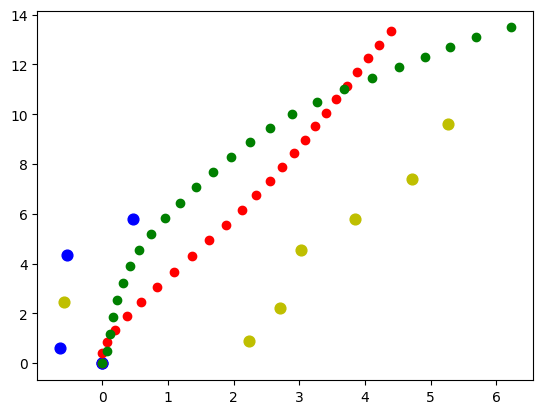

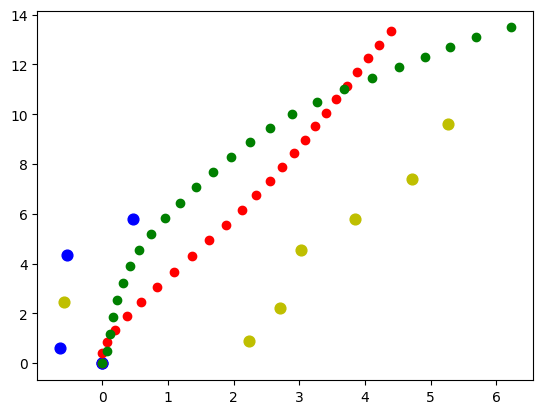

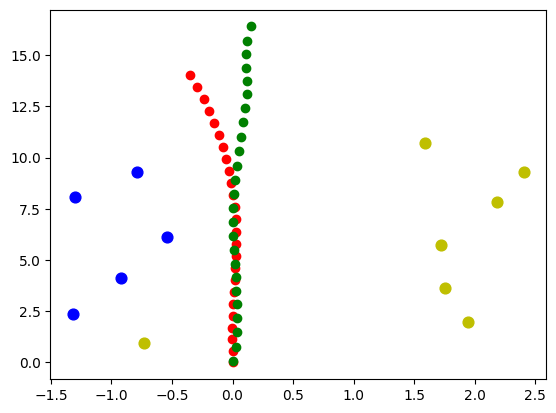

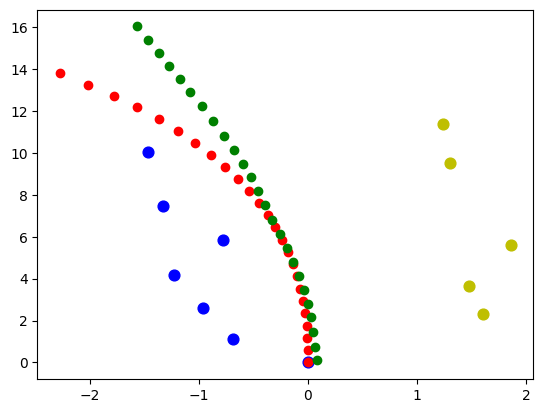

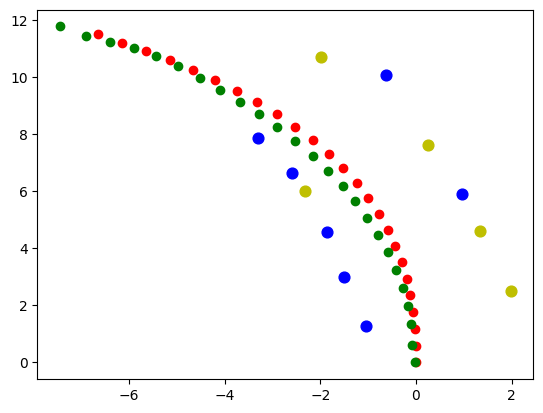

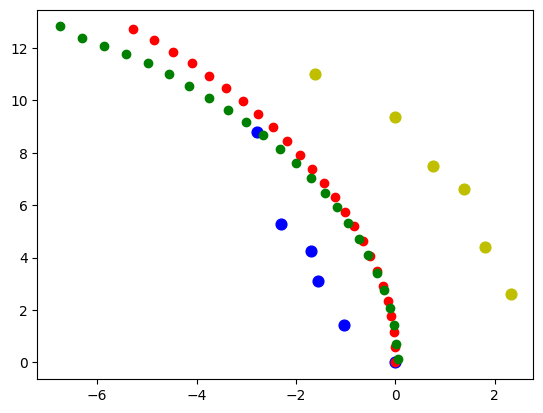

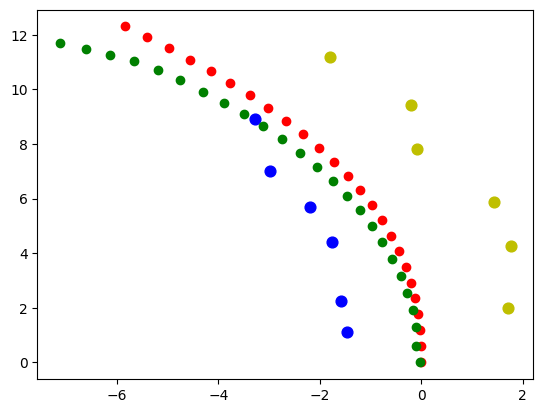

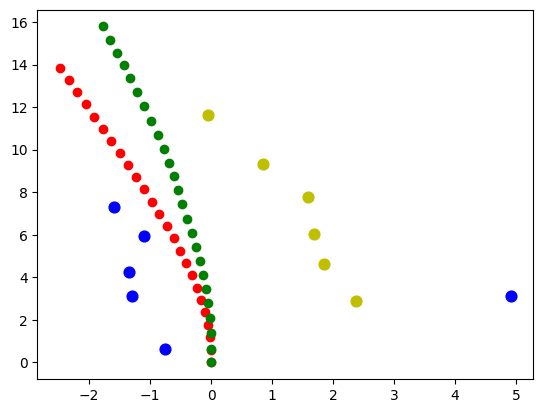

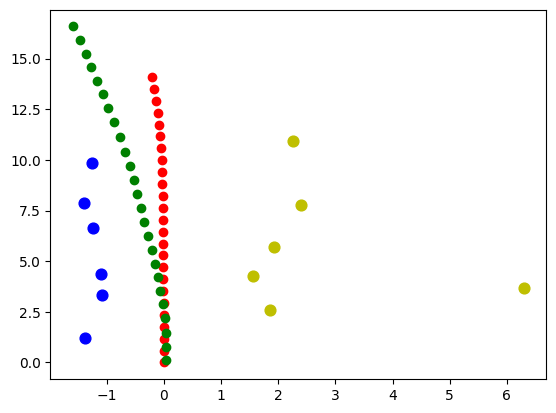

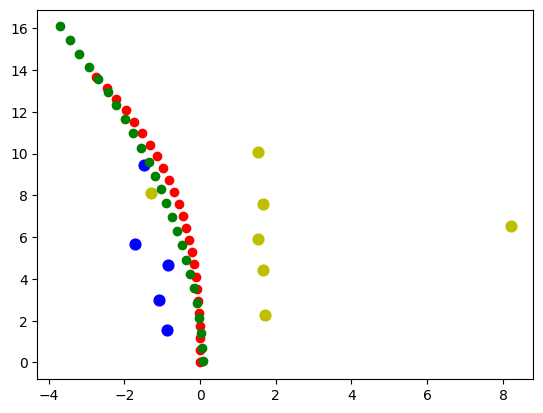

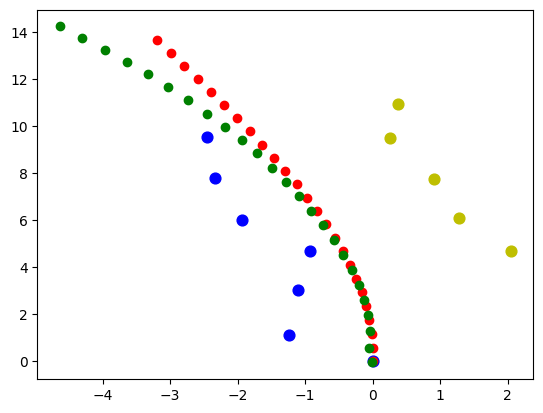

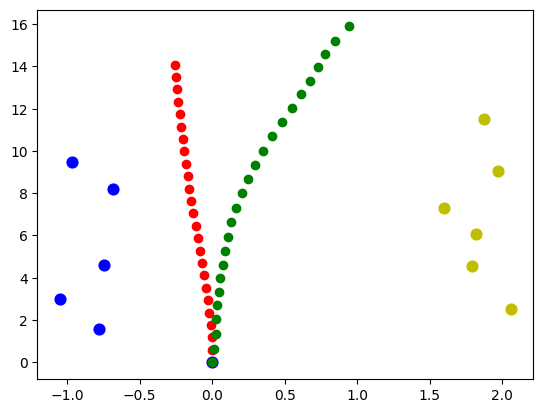

In [14]:
fig, ax = plt.subplots()
def track(val_dataloader):
    device =torch.device("cpu")
    model.to(device)
    model.eval()
    i = 0
    for batch_idx, (input, target) in enumerate(val_dataloader):



        input, target = input.to(device), target.to(device)


        pred = model(input, target.shape[1]).detach().numpy()  # Forward pass

        outputs = pred

        ax.clear()
        for i in range(input.shape[0]):
          if i >10:
            return

          ax.clear()
          ax.scatter(input[i][input[i][:,2]==0][:,0], input[i][input[i][:,2]==0][:,1], c='b',s=60)
          ax.scatter(input[i][input[i][:,2]==1][:,0], input[i][input[i][:,2]==1][:,1], c='y',s=60)
          ax.scatter(target[i][:,0], target[i][:,1], c = 'r')
          ax.scatter(outputs[i][:,0], outputs[i][:,1], c = 'g')
          display(fig)
          plt.pause(1)
          i+=1



track(train_dataloader)